# Gender Recognizer
In the era of rapidly advancing artificial intelligence, gender recognition has become a key area of research and application. This project focuses on developing a robust gender recognition model using advanced deep learning techniques. The objective of this project is to accurately classify gender based on visual data, leveraging the capabilities of modern convolutional neural networks (CNNs) and sophisticated training methodologies.

Throughout this project, we have implemented a comprehensive workflow to build, train, and evaluate a gender recognition model. Using a dataset from kaggle of labeled images, we trained a model architecture that could effectively distinguish between different gender classes. The model was rigorously evaluated using multiple performance metrics, including precision, recall, F1 score, and the Matthews Correlation Coefficient (MCC), all of which demonstrated the model’s high level of accuracy and reliability.

A key aspect of this project was the visualization and interpretation of model performance. We employed techniques such as confusion matrices, ROC curves, and detailed training curve plots to gain insights into the model's strengths and weaknesses. Additionally, the model’s predictions were visualized alongside the original images to provide a clear understanding of its decision-making process.

The development process also included ensuring the model's reproducibility and deployability. The trained model was saved for future use, allowing for easy deployment in real-world applications or further refinement. This project represents a significant step towards creating a reliable and accurate gender recognition system that could be utilized in various fields, including security, marketing, and human-computer interaction.

Overall, the successful development and evaluation of this gender recognition model underscore its potential for practical applications, providing a solid foundation for future work in this domain.

__Dataset source__: [Link](https://www.kaggle.com/datasets/humairmunir/gender-recognizer)

## Configuration Settings
### Libraries

In [70]:
import random, os, glob, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plotter
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
import seaborn as sns

import torch
import torchvision

from torchinfo import summary
from torch import nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import (Dataset, DataLoader)
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from scikitplot.metrics import plot_roc_curve

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support,
                             accuracy_score,
                             top_k_accuracy_score,
                             f1_score,
                             matthews_corrcoef,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Configuration settings for model training
This code defines a class `CFG` that holds configuration settings for training a machine learning model. Here's a breakdown of each attribute:<br>
* __DEVICE__: Determines whether to use a GPU (CUDA) or CPU based on the availability of CUDA-enabled devices.
* __NUM_DEVICES__: The number of CUDA devices available (GPUs).
* __NUM_WORKERS__: The number of CPU cores available for data loading and preprocessing.
* __NUM_CLASSES__: Specifies the number of output classes for the model (in this case, 2 classes).
* __EPOCHS__: The number of epochs (iterations over the entire dataset) for training the model.
* __BATCH_SIZE__: The size of each batch of data. If fewer than 2 CUDA devices are available, it uses a batch size of 32; otherwise, it scales the batch size according to the number of CUDA devices.
* __LR__: The learning rate for the optimizer.
* __APPLY_SHUFFLE__: A boolean indicating whether to shuffle the data before each epoch.
* __SEED__: A fixed seed value for reproducibility.
* __HEIGHT__: The height of input images.
* __WIDTH__: The width of input images.
* __CHANNELS__: The number of channels in the input images (e.g., RGB images have 3 channels).
* __IMAGE_SIZE__: A tuple representing the dimensions of the input images (height, width, channels).

In [2]:
class CFG:
    DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES=torch.cuda.device_count()
    #NUM_WORKERS=os.cpu_count()
    NUM_WORKERS=0
    NUM_CLASSES=2
    EPOCHS=15
    BATCH_SIZE=(
        32 if torch.cuda.device_count()<2
        else (32*torch.cuda.device_count())
    )
    #BATCH_SIZE=4
    LR=0.001  #0.001
    APPLY_SHUFFLE=True
    SEED=2024
    HEIGHT=256
    WIDTH=256
    CHANNELS=3
    IMAGE_SIZE=(256, 256, 3)

## Data Exploration
### Read Dataset
Defining images paths and getting images with glob

In [3]:
train_path=Path("dataset")
image_path_list=list(train_path.glob("*/*.jpg"))
print(f"Total Images = {len(image_path_list)}")

Total Images = 1195


### Preprocessing
#### Convert to DataFrame format
This code snippet creates a DataFrame containing image file paths and their corresponding labels.
* `images_path` and `labels` lists are initialized with `None` values, each having the length of `image_path_list`.

In [4]:
images_path=[None]*len(image_path_list)
labels=[None]*len(image_path_list)

for i, img_path in enumerate(image_path_list):
    images_path[i]=img_path
    labels[i]=img_path.parent.stem

dataset_df=pd.DataFrame({'image_path':images_path,
                         'label':labels})

dataset_df.head()

image_path label
0  dataset\MEN\20240609_175821.jpg   MEN
1  dataset\MEN\20240609_175941.jpg   MEN
2  dataset\MEN\20240609_175959.jpg   MEN
3  dataset\MEN\20240609_180022.jpg   MEN
4  dataset\MEN\20240609_180035.jpg   MEN

#### Distribution and characteristics plot of the created DataFrame

In [5]:
# Sort dataset_df by 'label' value counts
sorted_counts=dataset_df['label'].value_counts().sort_values(ascending=False)

# Create subplots
f, ax=plt.subplots(1, 2, figsize=(12, 5))

# Pie chart sorted by value counts
explode=[0]*len(sorted_counts)
explode[1]=0.1 # Explode the second slice

sorted_counts.plot.pie(explode=explode, autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('label')
ax[0].set_ylabel('')

# Count plot sorted by value counts
sns.countplot(x=dataset_df['label'], order=sorted_counts.index, ax=ax[1])
ax[1].set_title('label')

plt.show()

#### View random sample images
The function `_load` loads an image from a given path and can either return it as a PIL image or convert it to a tensor, based on the `as_tensor` flag.

In [6]:
def _load(images_path, as_tensor=True):
    
    image=Image.open(images_path)
    
    if as_tensor:
        converter=transforms.ToTensor()
        return converter(image)
    else:
        return image

The function `view_sample` visualizes an image with an optional color map and displays its corresponding label as as title on the plot.

In [7]:
def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f"Label: {label}", fontsize=16)
    plt.axis('off')
    
    return

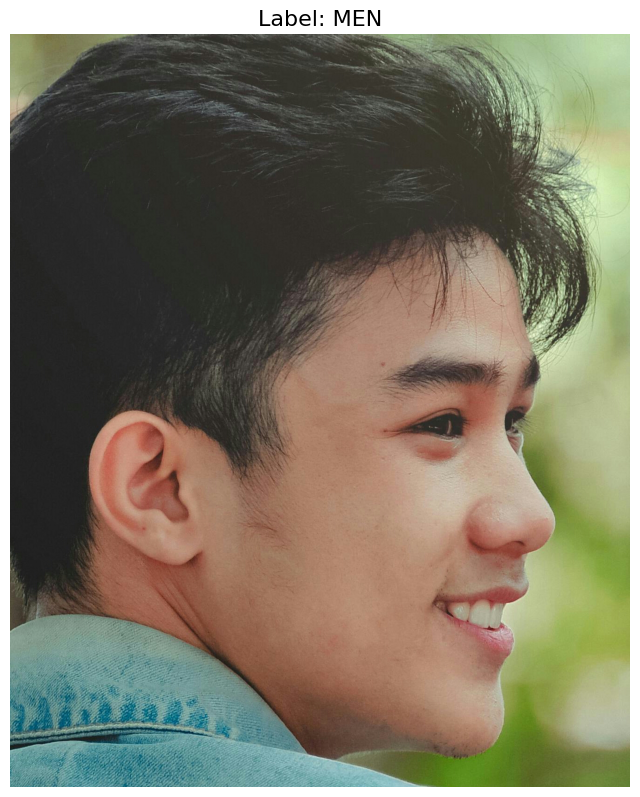

In [8]:
# Select random sample form train_df
idx=random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label=_load(dataset_df.image_path[idx]), dataset_df.label[idx]

# View the random sample
view_sample(sample_image.permute(1, 2, 0), sample_label)

In [9]:
def view_multiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    
    rows=count//5
    
    if count%5>0:
        rows+=1
    
    idx=random.sample(df.index.to_list(), count)
    fig=plt.figure(figsize=fig_size)
    
    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f"label: {df.label[_]}")
        plt.axis('off')
        
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0))
        else:
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0), cmap=color_map)
    
    return

In [10]:
view_multiple_samples(dataset_df,
                      _load,
                      count=20, # View 20 random sample images
                      fig_size=(20, 24)
                      )

### Split train/vaid/test data

In [11]:
# Split train data and temp data
# temp=valid+test

train_split_idx, temp_split_idx, _, _=(
    train_test_split(
        dataset_df.index,
        dataset_df.label,
        test_size=0.30,
        stratify=dataset_df.label,
        random_state=CFG.SEED
    )
)

In [12]:
train_df=dataset_df.iloc[train_split_idx].reset_index(drop=True)
temp_df=dataset_df.iloc[temp_split_idx].reset_index(drop=True)

# View shape
train_df.shape, temp_df.shape

((836, 2), (359, 2))

In [13]:
# Split valid data and test data

val_split_idx, test_split_idx, _, _=(
    train_test_split(
        temp_df.index,
        temp_df.label,
        test_size=0.5,
        stratify=temp_df.label,
        random_state=CFG.SEED
    )
)

In [14]:
val_df=temp_df.iloc[val_split_idx].reset_index(drop=True)
test_df=temp_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

((179, 2), (180, 2))

### View train/valid/test data counts

In [15]:
# Calculate sample sizes
train_size=len(train_df)
val_size=len(val_df)
test_size=len(test_df)
total=train_size+val_size+test_size

print(f"train samples count:\t\t{train_size}\t({(100*train_size/total):.2f}%)")
print(f"validation samples count:\t{val_size}\t({(100*val_size/total):.2f}%)")
print(f"test samples count:\t\t{test_size}\t({(100*test_size/total):.2f}%)")
print("="*50)
print(f"Total:\t\t\t\t{total}\t({(100*total/total):.2f}%)")

train samples count:		836	(69.96%)
validation samples count:	179	(14.98%)
test samples count:		180	(15.06%)
Total:				1195	(100.00%)


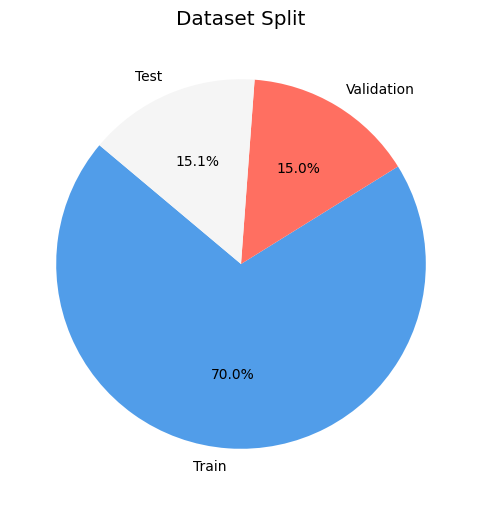

In [16]:
# Calculate percentages
train_percent=100*train_size/total
val_percent=100*val_size/total
test_percent=100*test_size/total

# Plotting
plt.figure(figsize=(10, 6))

# Pie chart
sizes=[train_size, val_size, test_size]
labels=['Train', 'Validation', 'Test']
colors=['#519DE9', '#FF6F61', '#F5F5F5']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Dataset Split')
plt.show()

Text(0.5, 1.0, 'train Vs. test')

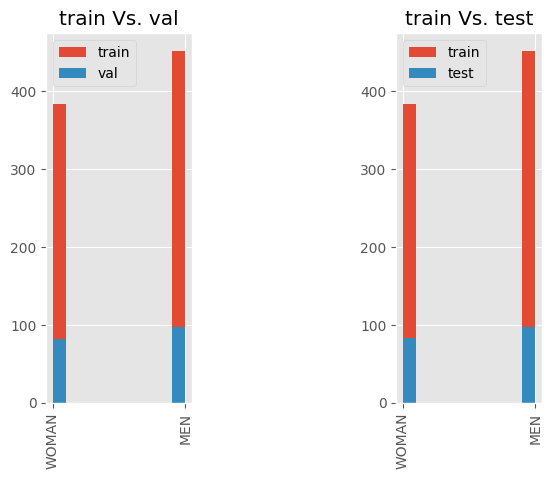

In [17]:
plt.subplot(1, 3, 1)
plt.hist(train_df['label'], label='train')
plt.hist(val_df['label'], label='val')
plt.legend()
plotter.xticks(rotation=90)
plt.title("train Vs. val")

plt.subplot(1, 3, 3)
plt.hist(train_df['label'], label='train')
plt.hist(test_df['label'], label='test')
plt.legend()
plotter.xticks(rotation=90)
plt.title("train Vs. test")

## Data Compose

`transforms.Compose` in PyTorch is a powerful utility designed to facilitate the composition of multiple image transformation operations. It is commonly used in the image preprocessing pipeline to apply a series of transformations in a specific sequence. These transformations can include operations such as resizing, cropping, rotation, normalization, and more. By chaining these transformations together, `transforms.Compose` ensures that each operation is applied in the correct order, which is crucial for preparing data consistently and effectively. This process is essential for standardizing and augmenting image data before it is fed into machine learning models for training or evaluation, thereby improving the model's performance and robustness.
### Augmenting training data
Augmenting training data refers to the process of artificially increasing the size and diversity of a dataset by applying various transformations to the existing data. This technique is particularly useful in machine learning and computer vision to improve the performance and generalization ability of models. Here’s how it works:
1. __Transformations__: Various transformations such as rotations, flips, zooms, shifts, and color adjustments are applied to the original images. These operations create new variations of the images that can help the model learn to recognize patterns and features in different contexts.
2. __Synthetic Data__: In addition to simple transformations, more complex techniques such as adding noise, altering lighting conditions, or using generative models can be used to create synthetic variations of the data.
3. __Regularization__: Data augmentation acts as a form of regularization, helping to prevent overfitting by making the model robust to different kinds of input variations.
4. __Improved Generalization__: By exposing the model to a wider variety of data during training, it becomes better at generalizing to unseen examples, which improves its performance on real-world data.

In [18]:
# Augment train data

train_transforms=transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

# Only reshape test data

test_transforms=transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.ToTensor()
])

In [19]:
# Select random sample from train_df
idx=random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image=_load(dataset_df.image_path[idx], as_tensor=False)

__View original image and Augmented image__

(-0.5, 255.5, 255.5, -0.5)

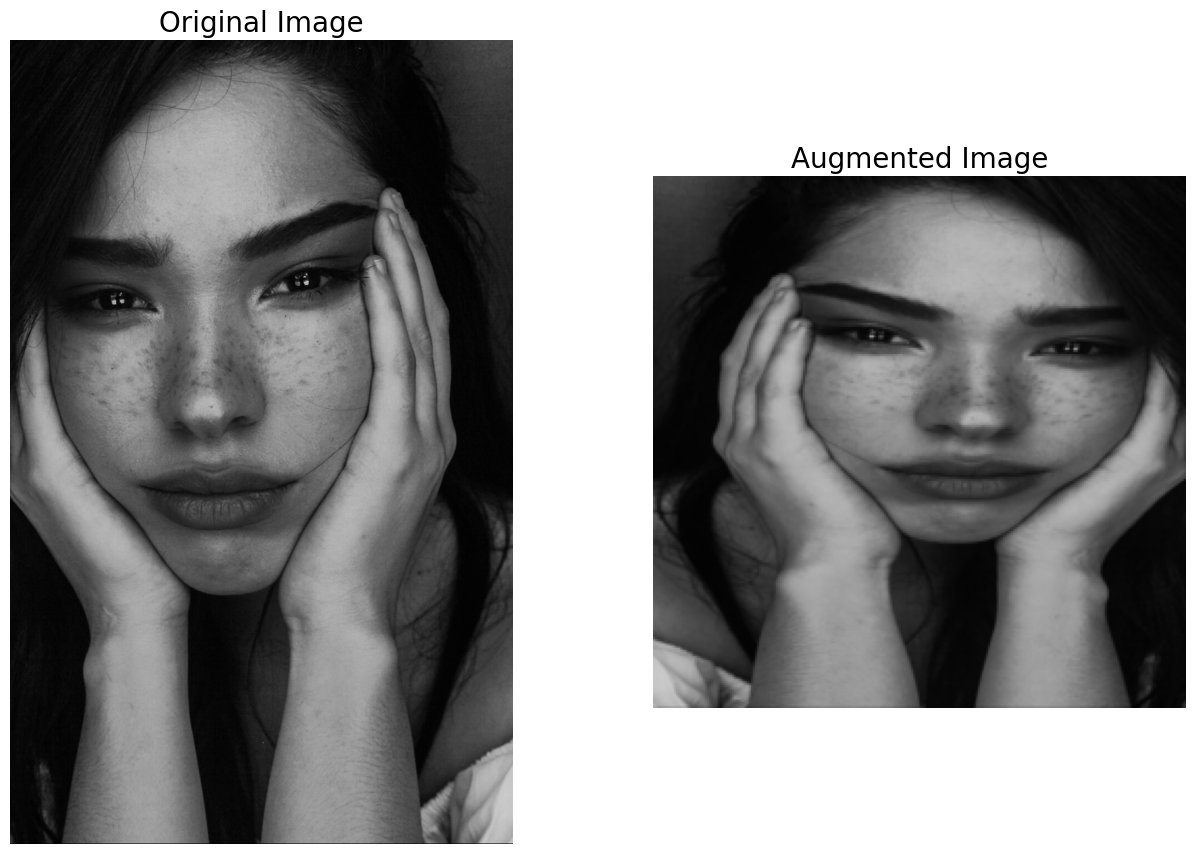

In [20]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View original image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image)
ax1.axis('off')

# View augmented image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0))
ax2.axis('off')

### Define gender recognizer Dataset
The `GRDataset` class is a custom dataset for PyTorch, designed to handle image data and their corresponding labels. It initializes with a DataFrame containing image paths and labels, and optionally applies data transformations. The class provides methods to load images, retrieve the length of the dataset, and fetch individual items by index. Images are loaded from specified paths and converted to RGB format, and labels are mapped to numerical indices. If transformations are specified, they are applied to the images before returning them. This setup allows for seamless integration with PyTorch’s data handling and model training processes.

In [21]:
class GRDataset(Dataset):
    
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths=df['image_path'].to_list()
        self.labels=df['label'].to_list()
        self.transform=transform
        
        self.classes=sorted(list(df['label'].unique()))
        self.class_to_idx={cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path=self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image=self.load_image(index)
        class_name=self.labels[index]
        class_idx=self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

### Build train/valid/test dataset

In [22]:
# Build train dataset
train_ds=GRDataset(train_df, transform=train_transforms)

# Build valid dataset
val_ds=GRDataset(val_df, transform=test_transforms)

# Build test dataset
test_ds=GRDataset(test_df, transform=test_transforms)

In [23]:
# Build train dataloader
train_loader=DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build valid dataloader
val_loader=DataLoader(
    dataset=val_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=(not CFG.APPLY_SHUFFLE)
)

# Build test dataloader
test_loader=DataLoader(
    dataset=test_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=(not CFG.APPLY_SHUFFLE)
)

## Build model
<span style="color:blue">EfficientNetB2.</span><br><br>
EfficientNet B2 is a highly optimized convolutional neural network architecture aimed at enhancing both the efficiency and performance of deep learning models. It belongs to the EfficientNet family, which was introduced by Google AI researchers in 2019. EfficientNet models stand out for their ability to achieve state-of-the-art accuracy in image classification tasks while ensuring computational efficiency. The architecture of EfficientNet B2, like other models in the EfficientNet series, leverages a combination of depthwise separable convolutions and a novel compound scaling method. This approach allows it to scale up network width, depth, and resolution in a balanced manner, resulting in a highly effective model that delivers superior performance with fewer parameters and less computational resource usage. EfficientNet B2's design makes it particularly suitable for applications where both accuracy and efficiency are critical, such as in mobile and edge devices.<br><br>
The provided code defines a function build_model that constructs and configures a deep learning model using PyTorch and torchvision. Here’s a general overview:

1. __Seed Initialization__: The function sets manual seeds for reproducibility, ensuring that the results can be consistently replicated. It uses `torch.manual_seed` and `torch.cuda.manual_seed` to set the seed for CPU and GPU computations, respectively.

2. __Model Weights__: It retrieves the default weights for the EfficientNet-B0 model from torchvision. This is done using `torchvision.models.EfficientNet_B0_Weights.DEFAULT`.

3. __Model Creation and Device Assignment__: The function creates an instance of the EfficientNet-B0 model with the pre-trained weights and assigns it to the specified device (e.g., CPU or GPU).

4. __Freezing Parameters__: It freezes the weights of the model’s feature extraction layers by setting `requires_grad` to `False`. This means that the gradients will not be computed for these layers during training, which prevents their weights from being updated.

5. __Custom Classifier__: The function replaces the original classifier head of the EfficientNet-B0 model with a new one. The new classifier consists of a `Flatten` layer, a `Dropout` layer (for regularization), and a `Linear` layer that maps to the number of classes specified in `CFG.NUM_CLASSES`.

6. __Return Model__: Finally, the function returns the modified model, which now includes the new classifier and is ready for training or evaluation.

Overall, this function sets up a pre-trained EfficientNet-B0 model for a specific classification task, with a customized classifier and model parameters configured for the given device.

In [24]:
def build_model(device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    # Set the manual seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Get model weights
    model_weights = (
        torchvision
        .models
        .EfficientNet_B0_Weights
        .DEFAULT
    )
    
    # Get model and push to device
    model=(
        torchvision.models.efficientnet_b0(
            weights=model_weights
        )
    ).to(device) 
    
    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Define new classifier and push to the target device
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.2, inplace=True), 
        nn.Linear(
            in_features=1280, out_features=CFG.NUM_CLASSES,bias=True
        )
    ).to(device)
    
    return model

In [25]:
# Generate model
efficientnet_B0=build_model(device=CFG.DEVICE)

# If using GPU setup, use this
efficientnet_B0=nn.DataParallel(efficientnet_B0)

# View model summary
summary(
    model=efficientnet_B0,
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
DataParallel (DataParallel)                                       [32, 3, 256, 256]    [32, 2]              --                   Partial
├─EfficientNet (module)                                           [32, 3, 256, 256]    [32, 2]              --                   Partial
│    └─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 16, 128, 128]   (1,448)              False
│    │    └─Sequential (2)                                        [32, 16, 128, 128]   [32, 24, 64, 64]     (16,714)             False
│    │    └─Sequential (3)                     

## Trainig
### Define loss function and optimizer

In [26]:
# Define loss function
loss_fn=nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define optimizer: Adam
optimizer=torch.optim.Adam(
    efficientnet_B0.parameters(),
    lr=CFG.LR # learning rate
)

### Define epoch execution step
The `execute_epoch` function is responsible for running a single training epoch for a given deep learning model in PyTorch. Here’s a general summary:

1. __Model Preparation__: The function sets the model to training mode using `model.train()`, which enables features like dropout and batch normalization.

2. __Initialization__: It initializes variables to keep track of the total training loss and accuracy for the epoch.

3. __Training Loop__: It iterates over the data provided by the dataloader:
    * _Data Transfer_: Moves the input data (`X`) and target labels (`y`) to the specified device (CPU or GPU).
    * _Forward Pass_: Passes the data through the model to get predictions and calculates the loss using the provided loss function.
    * _Loss Accumulation_: Adds the computed loss to the total training loss.
    * _Backward Pass_: Resets the gradients, computes the gradients for the loss, and performs an optimization step to update the model weights.
    * _Accuracy Calculation_: Computes the predicted class labels, compares them with the true labels, and updates the total training accuracy.

4. __Metric Calculation__: After processing all batches, it computes the average training loss and accuracy for the epoch.

5. __Return Values__: The function returns the average loss and accuracy for the epoch.

In essence, this function handles the core training operations for a model, including forward and backward passes, and calculates performance metrics.

In [27]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc=0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y=X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred=model(X)
        loss=loss_fn(y_pred, y)
        train_loss+=loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class=torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc+=(predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss=train_loss/len(dataloader)
    train_acc=train_acc/len(dataloader)
    
    return train_loss, train_acc

### Define evaluate step
The `evaluate` function performs model evaluation for a given dataset using PyTorch. Here’s a general summary:

1. __Model Preparation__: The function sets the model to evaluation mode with `model.eval()`, which disables features like dropout and batch normalization that are only used during training.

2. __Initialization__: It initializes variables to keep track of total evaluation loss and accuracy.

3. __Inference Context__: It uses `torch.inference_mode()` to disable gradient computation during evaluation, which reduces memory usage and speeds up inference.

4. __Evaluation Loop__: The function processes data from the `dataloader`:
    * _Data Transfer_: Moves the input data (`X`) and labels (`y`) to the specified device (CPU or GPU).
    * _Forward Pass_: Passes the data through the model to get predictions and computes the loss using the provided loss function.
    * _Loss Accumulation_: Adds the computed loss to the total evaluation loss.
    * _Accuracy Calculation_: Computes the predicted class labels, compares them to the true labels, and updates the total evaluation accuracy.

5. __Metric Calculation__: After processing all batches, it calculates the average evaluation loss and accuracy.

6. __Return Values__: The function returns the average loss and accuracy for the evaluation.

In summary, this function evaluates a model's performance on a dataset, calculates loss and accuracy metrics, and returns these metrics for further analysis.

In [28]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc=0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y=X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred=model(X)
            loss=loss_fn(y_pred, y)
            eval_loss+=loss.item() 

            # Compute Batch Metrics
            predicted_class= torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc+=(predicted_class==y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss=eval_loss/len(dataloader)
    eval_acc=eval_acc/len(dataloader)
    
    return eval_loss, eval_acc

### Building training loops
The `train` function manages the training and evaluation process for a model over a specified number of epochs. Here’s a brief overview:

1. __Initialization__: It initializes a session dictionary to store metrics such as training loss, training accuracy, evaluation loss, and evaluation accuracy.

2. __Training Loop__: For each epoch:
    * It prints the current epoch number.
    * Calls the `execute_epoch` function to train the model on the training data and obtain training metrics.
    * Calls the evaluate function to assess the model's performance on evaluation data and obtain evaluation metrics.
    * Logs and prints the metrics for the epoch.
    * Records the metrics in the session dictionary.

3. __Return Metrics__: After completing all epochs, it returns the session dictionary containing the recorded metrics for further analysis.

In summary, this function handles the entire training process, including periodic evaluation and logging of metrics to track the model's performance throughout the training.

In [29]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss':[],
        'accuracy':[],
        'eval_loss':[],
        'eval_accuracy':[]
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc=execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc=evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )     
               
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)
        
        
    # Return Session Metrics
    return session

### Training phase

Here’s a brief overview:

1. __Print Statements__: It prints information about the training process, including the model being trained, the number of training and validation samples, and a separator line for clarity.

2. __Session Configuration__: It creates a dictionary `session_config` that holds all necessary parameters for the training process, including:
    * The model to be trained (`efficientnet_B0`).
    * Data loaders for training and validation datasets (`train_loader` and `val_loader`).
    * The optimizer and loss function to be used.
    * The number of epochs for training.
    * The device (CPU or GPU) where training will occur (`CFG.DEVICE`).

3. __Training Execution__: It calls the `train` function with the unpacked `session_config` dictionary. This function handles the model training and evaluation process, and the resulting training history is stored in `session_history`.

In summary, this code sets up and starts the training of the EfficientNet model using specified configurations and logs the training progress.

In [30]:
# Train the model 
print('Training EfficientNet Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('='*50)

session_config = {
    'model':efficientnet_B0,
    'train_dataloader':train_loader,
    'eval_dataloader':val_loader,
    'optimizer':optimizer,
    'loss_fn':loss_fn,
    'epochs':CFG.EPOCHS,
    'device':CFG.DEVICE
}

session_history = train(**session_config)

Training EfficientNet Model
Train on 836 samples, validate on 179 samples.


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.5312 - acc: 0.7998 - eval_loss: 0.4439 - eval_acc: 0.8731

Epoch 2/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3783 - acc: 0.9225 - eval_loss: 0.3501 - eval_acc: 0.9167

Epoch 3/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3496 - acc: 0.9062 - eval_loss: 0.3316 - eval_acc: 0.9219

Epoch 4/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3417 - acc: 0.9190 - eval_loss: 0.3171 - eval_acc: 0.9375

Epoch 5/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3279 - acc: 0.9410 - eval_loss: 0.3099 - eval_acc: 0.9531

Epoch 6/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3192 - acc: 0.9352 - eval_loss: 0.3061 - eval_acc: 0.9531

Epoch 7/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3374 - acc: 0.9363 - eval_loss: 0.3036 - eval_acc: 0.9583

Epoch 8/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3301 - acc: 0.9259 - eval_loss: 0.3097 - eval_acc: 0.9375

Epoch 9/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3183 - acc: 0.9329 - eval_loss: 0.3017 - eval_acc: 0.9531

Epoch 10/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3016 - acc: 0.9560 - eval_loss: 0.2999 - eval_acc: 0.9479

Epoch 11/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3063 - acc: 0.9491 - eval_loss: 0.3004 - eval_acc: 0.9583

Epoch 12/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3107 - acc: 0.9537 - eval_loss: 0.3001 - eval_acc: 0.9531

Epoch 13/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3024 - acc: 0.9560 - eval_loss: 0.2957 - eval_acc: 0.9583

Epoch 14/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3088 - acc: 0.9525 - eval_loss: 0.2969 - eval_acc: 0.9479

Epoch 15/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3041 - acc: 0.9502 - eval_loss: 0.2961 - eval_acc: 0.9531


### Model storage
To __save__ the model generated in PyTorch, you can use the `torch_save` function. 

In [49]:
def save_model(model, save_path):
    
    # Extract the directory from the save_path
    directory=os.path.dirname(save_path)
    
    # Check if the directory exist, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Save the model's state_dict
    torch.save(model.state_dict(), save_path)
    print(f"Model save to {save_path}")

In [50]:
model_save_path="saved_models/efficientnet_B0.pth"
save_model(efficientnet_B0, model_save_path)

Model save to saved_models/efficientnet_B0.pth


If you want to load the model later, you can do so like this:

In [52]:
def load_model(model_class, model_path, device):
    # Initialize the model (assuming it has the same architecture as when it was saved)
    model=model_class(weights=models.EfficientNet_B0_Weights.DEFAULT)
    
    # Load the saved state_dict into the model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)  # Move the model to the specified device (CPU or GPU)
    model.eval()  # Set the model to evaluation mode
    
    print(f"Model loaded from {model_path}")
    return model

In [ ]:
model_path="saved_models/efficientnet_B0.pth"
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=load_model(models.efficientnet_b0, model_path, device)

### Define prediction method
The `predict` function performs inference on a dataset using a trained model. Here’s a brief overview:

1. __Model Preparation__: Sets the model to evaluation mode using `model.eval()`, which prepares it for inference by disabling dropout and batch normalization.

2. __Initialization__: Initializes an empty list `predictions` to store the model’s prediction results.

3. __Inference Context__: Uses `torch.inference_mode()` to disable gradient calculation during inference, optimizing performance.

4. __Inference Loop__: Iterates over the data from sample_loader:
    * _Data Transfer_: Moves input data (`X`) and labels (`y`) to the specified device (CPU or GPU).
    * _Model Prediction_: Feeds data through the model to get predictions.
    * _Probability Computation_: Applies the softmax function to get class probabilities, then converts the results to NumPy arrays and adds them to the `predictions` list.

5. __Return Results__: Stacks all the predictions into a single NumPy array using `np.vstack` and returns it.

In summary, this function runs inference on a dataset, collects the predicted probabilities, and returns them as a NumPy array.

In [31]:
def predict(model:nn.Module,
            sample_loader:torch.utils.data.DataLoader,
            device:torch.device)->np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions=[]
    
    # Activate inference context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y=X.to(device), y.to(device)
            
            # feed-forward and compute metrics
            y_pred=model(X)
            
            # Compute batch metrics
            predicted_probs=torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
            
    return np.vstack(predictions)

### Test sample probabilities

In [32]:
test_probs=predict(efficientnet_B0, test_loader, CFG.DEVICE)
test_preds=np.argmax(test_probs, axis=1)
test_preds

  0%|          | 0/6 [00:00<?, ?it/s]

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1], dtype=int64)

## Model performance analysis & results
### Plotting the model performance record
The `plot_training_curves` function is used to visualize the training and evaluation metrics of a machine learning model over epochs. Here’s a brief overview of what the code does:

1. __Extract Metrics__: Converts the training and evaluation loss and accuracy data from the `history` dictionary into NumPy arrays.

2. __Prepare Epochs__: Creates a range object for the number of epochs, which will be used as the x-axis for the plots.

3. __Create Plots__: Initializes a figure with two subplots:
    * __Loss Plot__:
        * Plots training loss and evaluation loss over epochs.
        * Highlights the areas where training loss is higher or lower than evaluation loss with different colors.
        * Sets the title and labels for the loss plot.
    * __Accuracy Plot__:
        * Plots training accuracy and evaluation accuracy over epochs.
        * Highlights the areas where training accuracy is higher or lower than evaluation accuracy with different colors.
        * Sets the title and labels for the accuracy plot.

4. __Styling__:
    * Uses `sns.despine()` to remove the top and right spines of the plots for a cleaner look.

5. __Return__: The function doesn’t return any values; it just displays the plots.

In summary, this function generates visualizations for both loss and accuracy metrics across training epochs, providing a way to analyze the model's performance and detect potential issues like overfitting or underfitting.

In [36]:
def plot_training_curves(history):
    
    loss=np.array(history['loss'])
    val_loss=np.array(history['eval_loss'])
    
    accuracy=np.array(history['accuracy'])
    val_accuracy=np.array(history['eval_accuracy'])
    
    epochs=range(len(history['loss']))
    
    fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss>val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss<val_loss), color='C1', alpha=0.3, interpolate=True)
    
    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy>val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy<val_accuracy), color='C1', alpha=0.3, interpolate=True)
    
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend()
    
    sns.despine()
    
    return

In [37]:
# Convert history dict to DataFrame
session_history_df=pd.DataFrame(session_history)
session_history_df

loss  accuracy  eval_loss  eval_accuracy
0   0.531227  0.799769   0.443922       0.873081
1   0.378294  0.922454   0.350079       0.916667
2   0.349564  0.906250   0.331591       0.921875
3   0.341743  0.918981   0.317139       0.937500
4   0.327911  0.940972   0.309912       0.953125
5   0.319250  0.935185   0.306058       0.953125
6   0.337415  0.936343   0.303567       0.958333
7   0.330140  0.925926   0.309652       0.937500
8   0.318307  0.932870   0.301703       0.953125
9   0.301564  0.956019   0.299899       0.947917
10  0.306337  0.949074   0.300409       0.958333
11  0.310703  0.953704   0.300127       0.953125
12  0.302380  0.956019   0.295691       0.958333
13  0.308766  0.952546   0.296877       0.947917
14  0.304121  0.950231   0.296111       0.953125

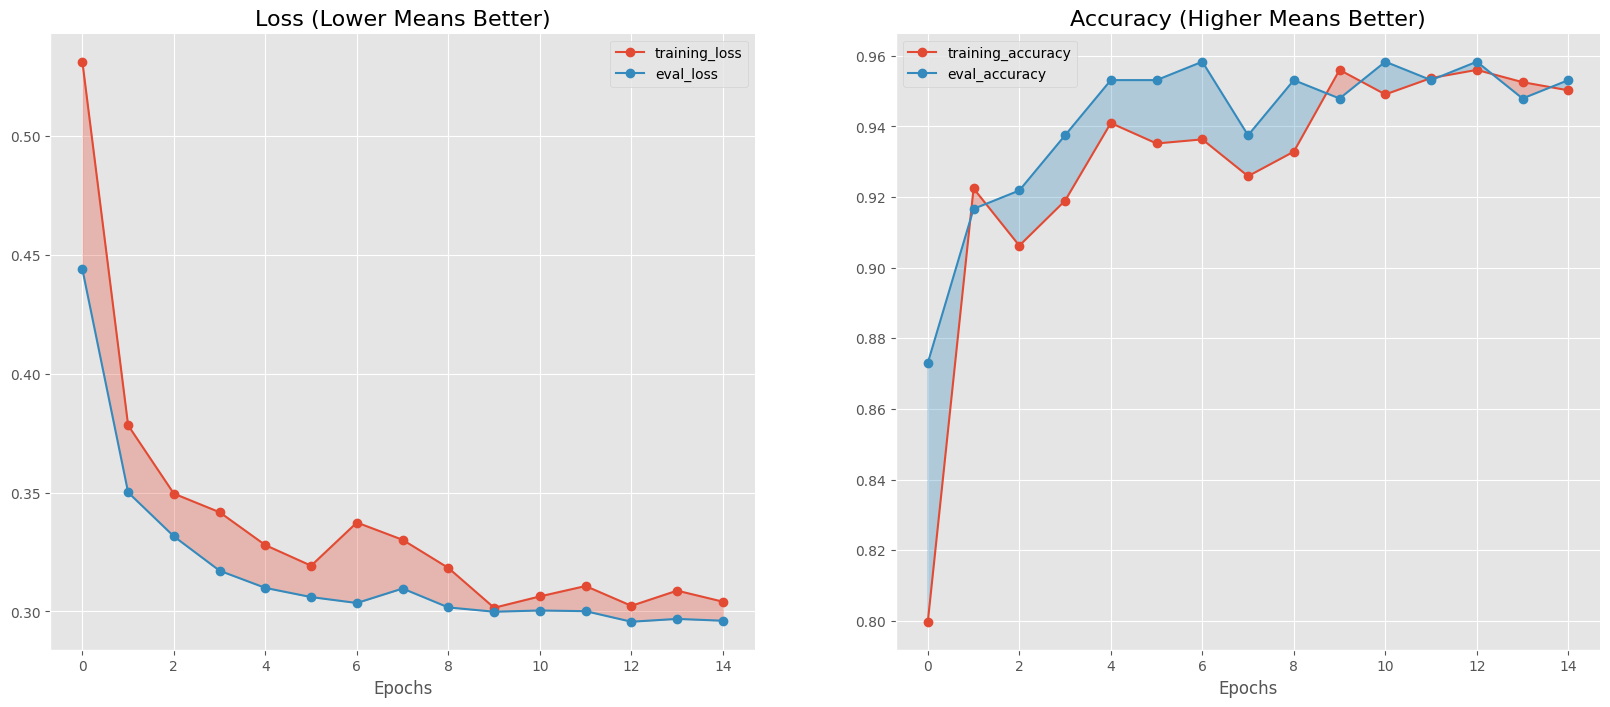

In [38]:
# Plot EfficientNet session training history
plot_training_curves(session_history)

### Plotting the model confusion matrix
The `plot_confusion_matrix` function is designed to visualize a confusion matrix, which is a common evaluation tool used in classification tasks to understand the performance of a machine learning model. Here's a general explanation:

1. __Generate Confusion Matrix__:
   - The function first computes the confusion matrix using the true labels (`y_true`) and predicted labels (`y_pred`). This matrix summarizes the number of correct and incorrect predictions by comparing actual and predicted labels.

2. __Set Plot Size__:
   - The size of the plot is set using the `figsize` parameter to ensure that the matrix is clearly visible.

3. __Create Confusion Matrix Heatmap__:
   - A heatmap of the confusion matrix is created using Seaborn's `heatmap` function.
   - The heatmap displays the values in the confusion matrix with annotations (`annot=True`), where the values are displayed as integers (`fmt='g'`).
   - The color scheme is set to 'plasma', and additional formatting options like `text_size` for the annotations, `linewidths` for grid lines, and `xticklabels`/`yticklabels` for class labels are configured.

4. __Set Title and Axis Labels__:
   - The function sets a title "Confusion Matrix" and labels for the x-axis (Predicted Label) and y-axis (True Label) to provide context for the heatmap.

5. __Display the Plot__:
   - The function then shows the plot using `plt.show()`.

6. __Return__:
   - The function does not return any value; it simply displays the confusion matrix heatmap.

In summary, this function creates and displays a visually appealing confusion matrix to help evaluate the performance of a classification model, making it easy to see where the model's predictions are correct or incorrect. 

In [44]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    
    # Generate confusion matrix
    cm=confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)
    
    # Create confusion matrix heatmap
    disp=sns.heatmap(
        cm, annot=True, cmap='plasma',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes
    )
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)
    
    # Plot confusion matrix
    plt.show()
    
    return

This line of code is used to generate a list of numeric labels corresponding to the class names in the `test_ds` dataset. Here's how it works:

1. __`test_ds.labels`__: This refers to the list of labels (typically class names as strings) associated with the data samples in the `test_ds` dataset.

2. __`test_ds.class_to_idx.get`__: This is a dictionary method used to map class names (strings) to their corresponding numeric indices. The `get` method retrieves the value associated with each class name key.

3. __`map(...)`__: The `map` function applies the `get` method from the `class_to_idx` dictionary to each label in `test_ds.labels`. It returns an iterable of numeric indices corresponding to each class label.

4. __`[*...]`__: The `[*...]` syntax is used to unpack the iterable returned by `map` into a list.

As a result, `test_labels` becomes a list of numeric labels that correspond to the class names in the dataset, which are often required for further analysis, such as evaluating a model's performance or computing metrics.

In [40]:
test_labels=[*map(test_ds.class_to_idx.get, test_ds.labels)]

In [42]:
accuracy=accuracy_score(test_labels, test_preds)
print(f"Accuracy is: {np.round(accuracy*100, 3)}%")

Accuracy is: 93.889%


In [45]:
plot_confusion_matrix(test_labels,
                      test_preds,
                      figsize=(4, 4),
                      classes=test_ds.classes)

### Random prediction visualization

This function `visualize_predictions` will help you visualize the model’s predictions on a random selection of images from the test dataset.

1. __`model.eval()`__: Puts the model in evaluation mode, disabling certain layers like dropout.

2. __`random.sample(range(len(test_dataset)), num_images)`__: Randomly selects 12 indices from the test dataset.

3. __`image.unsqueeze(0).to(device)`__: Adds a batch dimension to the image tensor and sends it to the appropriate device (CPU or GPU).

4. __`with torch.inference_mode()`__: Disables gradient calculation, which is not needed during inference and saves memory.

5. __`torch.argmax(torch.softmax(y_pred, dim=1), dim=1).item()`__: Applies softmax to the model's output to get probabilities, then selects the class with the highest probability as the predicted label.

6. __`image.permute(1, 2, 0).cpu().numpy()`__: Rearranges the dimensions of the image tensor for proper visualization (from CHW to HWC) and moves it back to the CPU.

7. __`plt.subplot(3, 4, i + 1)`__: Arranges the images in a 3x4 grid.

8. __`ax.set_title(...)`__: Sets the title of each subplot to display the true label and predicted label.

In [46]:
def visualize_predictions(model, test_dataset, device, num_images=12):
    
    # Set the model to evaluation mode
    model.eval()
    
    # Randomly select 12 indices from the test dataset
    indices=random.sample(range(len(test_dataset)), num_images)
    
    # Create a figura to display the images
    plt.figure(figsize=(20, 12))
    
    for i, idx in enumerate(indices):
        # Load the image and label
        image, true_label=test_dataset[idx]
        
        # Prepare the image for model prediction
        image_tensor=image.unsqueeze(0).to(device)
        
        # Make a prediction
        with torch.inference_mode():
            y_pred=model(image_tensor)
            predicted_label=torch.argmax(torch.softmax(y_pred, dim=1), dim=1).item()
        
        # Get the label names (assuming test_dataset has clas_to_idx)
        true_label_name=test_dataset.classes[true_label]
        predicted_label_name=test_dataset.classes[predicted_label]
        
        # Display the image
        ax=plt.subplot(3, 4, i+1)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"True: {true_label_name}\nPred: {predicted_label_name}", fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return

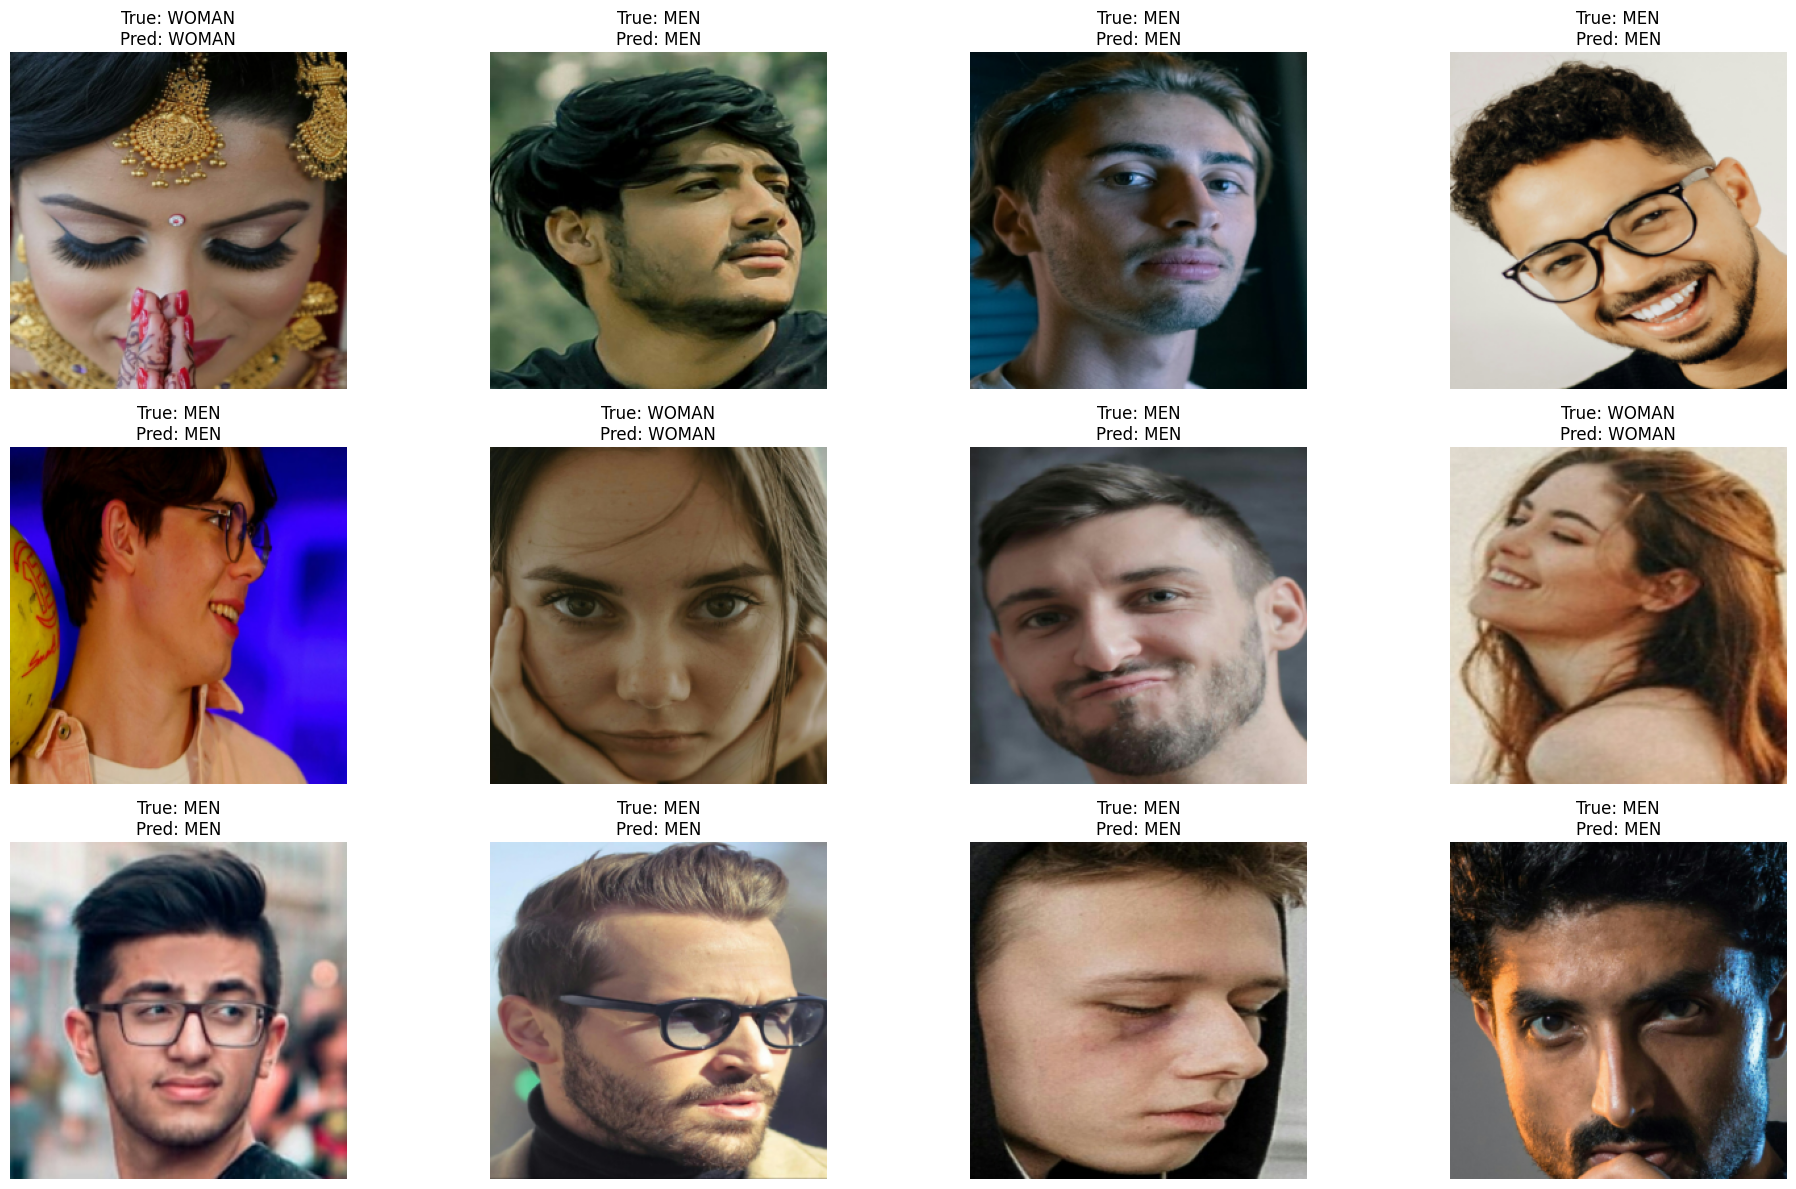

In [47]:
visualize_predictions(efficientnet_B0, test_ds, CFG.DEVICE)

### Visualizing scores
This code creates a DataFrame named `Visualization_predict` that holds accuracy data for a model's predictions on the test dataset. It then visualizes this accuracy as a horizontal bar plot using `seaborn`. The accuracy values are sorted in descending order, and the plot displays the accuracy on the x-axis with labels on the y-axis. The figure size is set to 9x0.4 inches, and the x-axis is limited to the range [0,1]. Finally, the plot is displayed using `plt.show()`.


In [57]:
#DataFrame
Visualization_models=[('test data', accuracy)]                                          
Visualization_predict=pd.DataFrame(data = Visualization_models, columns=[' ', 'Accuracy'])

#Visualization
f, axe=plt.subplots(1,1, figsize=(9,0.4))
Visualization_predict.sort_values(by=['Accuracy'], ascending=False, inplace=True)
sns.barplot(x='Accuracy', y=' ',  data = Visualization_predict, ax = axe)
axe.set_xlabel('Accuracy', size=10)
axe.set_ylabel(' ', size=10)
axe.set_xlim(0,1.0)
plt.show()

### Plotting the model ROC

#### ROC Curve Explanation
The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a classification model. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various threshold settings. The curve helps to visualize the trade-offs between true positives and false positives, and the area under the ROC curve (AUC) provides a measure of the model's overall ability to distinguish between classes.

#### Code Explanation
The code snippet `plot_roc(test_labels, test_probs, figsize=(8, 6), title_fontsize='large');` aims to plot the ROC curve for a given set of predictions:

- __`test_labels`__: True labels for the test data.
- __`test_probs`__: Predicted probabilities from the model for the positive class.
- __`figsize=(8, 6)`__: Specifies the size of the plot (8 inches wide by 6 inches tall).
- __`title_fontsize='large'`__: Sets the font size for the plot title to 'large'.

The overall goal is to visualize the ROC curve to assess the performance of the model in distinguishing between classes based on the predicted probabilities.

In [77]:
def plot_roc(y_true, y_scores, figsize=(8, 6), title_fontsize='large'):
    # Check if y_scores is a 2D array (e.g., for multi-class) and extract the positive class probabilities
    if y_scores.ndim == 2:
        if y_scores.shape[1] == 2:
            y_scores = y_scores[:, 1]  # Use probabilities for the positive class
        else:
            raise ValueError("For multi-class classification, y_scores should have 2 columns.")
    
    # Check if y_scores is now a 1D array
    if y_scores.ndim != 1:
        raise ValueError("y_scores should be a 1D array for binary classification.")
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=title_fontsize)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return

In [78]:
plot_roc(test_labels, test_probs, figsize=(8, 6), title_fontsize='large')

### Predicted Score Results

In [83]:
print(
    classification_report(
        test_labels,
        test_preds,
        target_names=test_ds.classes
    )
)

              precision    recall  f1-score   support

         MEN       0.91      0.98      0.95        97
       WOMAN       0.97      0.89      0.93        83

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



The function, `generate_performance_scores`, is used to calculate and display various performance metrics for a classification model. Here’s a brief explanation of each part:

1. __Function Definition__:
   - __`generate_performance_scores(y_true, y_pred, p_probabilities)`__: This function takes three arguments:
     - `y_true`: The true labels.
     - `y_pred`: The predicted labels from the model.
     - `p_probabilities`: Probabilities predicted by the model (though it's not used in the function).

2. __Performance Metrics Calculation__:
   - __`accuracy_score(y_true, y_pred)`__: Computes the accuracy of the model, which is the proportion of correctly predicted instances.
   - __`precision_recall_fscore_support(y_true, y_pred, average='weighted')`__: Calculates precision, recall, and F1 score, using a weighted average method that takes into account the imbalance of class distribution.
   - __`matthews_corrcoef(y_true, y_pred)`__: Computes the Matthews correlation coefficient, a metric that considers true and false positives and negatives to measure the quality of binary classifications.

3. __Display Results__:
   - __Print Statements__: Prints the computed metrics in a formatted and readable way, with lines and separators to clearly distinguish each metric.

4. __Return Value__:
   - __`performance_scores` Dictionary__: Contains the calculated metrics and returns them. The dictionary includes:
     - `accuracy_score`: Accuracy of the model.
     - `precision_score`: Weighted precision.
     - `recall_score`: Weighted recall.
     - `f1_score`: Weighted F1 score.
     - `matthews_corrcoef`: Matthews correlation coefficient.

This function is useful for evaluating and summarizing the performance of a classification model in a clear and organized manner.

In [88]:
def generate_performance_scores(y_true, y_pred, p_probabilities):
    
    model_accuracy=accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _=(
        precision_recall_fscore_support(
            y_true, y_pred, average='weighted'
        )
    )
    model_matthews_corrcoef=matthews_corrcoef(y_true, y_pred)
    
    print("="*35)
    print(f"\nPerformance Metrics:\n")
    print("="*35)
    print("_"*35)
    print(f'precision_score:\t{model_precision:.4f}\n')
    print("_"*35)
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print("_"*35)
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print("_"*35)
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print("="*35)
    
    performance_scores={
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'fi_score': model_f1,
        'matthews_coorcoef': model_matthews_corrcoef
    }
    
    return performance_scores

In [89]:
# Generate EfficieNet model performance scores

model_performance=generate_performance_scores(
    test_labels,
    test_preds,
    test_probs
)


Performance Metrics:

___________________________________
precision_score:	0.9412

___________________________________
recall_score:		0.9389

___________________________________
f1_score:		0.9386

___________________________________
matthews_corrcoef:	0.8790



### Predicted results convert to DataFrame format

In [90]:
results_df0 = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : test_preds,
})

submission0=results_df0

submission0.to_csv('results_df0.csv', index=False)
submission0

image_path  label  label_encoded  model_prediction
0             dataset\WOMAN\0184.jpg  WOMAN              1                 1
1             dataset\WOMAN\0037.jpg  WOMAN              1                 1
2    dataset\MEN\20240705_143202.jpg    MEN              0                 0
3    dataset\MEN\20240609_200449.jpg    MEN              0                 0
4    dataset\MEN\20240705_113358.jpg    MEN              0                 0
..                               ...    ...            ...               ...
175  dataset\MEN\20240609_180726.jpg    MEN              0                 0
176           dataset\WOMAN\0021.jpg  WOMAN              1                 1
177           dataset\WOMAN\0477.jpg  WOMAN              1                 1
178  dataset\MEN\20240609_181507.jpg    MEN              0                 0
179           dataset\WOMAN\0117.jpg  WOMAN              1                 1

[180 rows x 4 columns]

## Conclusion

### Model Performance Summary

The model has been evaluated with the following performance metrics:

* Precision Score: 0.9412
* Recall Score: 0.9389
* F1 Score: 0.9386
* Matthews Correlation Coefficient (MCC): 0.8790

The model demonstrates excellent performance across all evaluated metrics. The precision score of 0.9412 indicates that the model is highly effective at correctly identifying positive instances among all the instances it predicts as positive. The recall score of 0.9389 reflects that the model successfully captures a significant proportion of actual positive instances. With an F1 score of 0.9386, the model achieves a balanced performance in both precision and recall, suggesting a robust overall accuracy. The Matthews Correlation Coefficient of 0.8790 further highlights the model's strength, showing a high correlation between the predicted and true labels, which is particularly valuable in imbalanced datasets.

Overall, the model's high scores in precision, recall, F1, and MCC suggest that it performs well and is reliable for making predictions on the given dataset.